# Assignment 1 — Fish Dataset (Kaggle) — EDA + KFold CNN

Minimal, practical solution using **ImageFolder**.
We create a clean classification directory **once** (images only, no GT), then proceed normally.


In [1]:
%pip -q install kagglehub torch torchvision scikit-learn matplotlib pillow numpy tqdm mlflow



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.auto import tqdm

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os
import mlflow
import mlflow.pytorch

mlflow.set_tracking_uri(os.environ.get("MLFLOW_TRACKING_URI", "file:./mlruns"))
experiment_name = os.environ.get(
    "MLFLOW_EXPERIMENT_NAME", "fish_kfold_smallcnn")
mlflow.set_experiment(experiment_name)

print("MLflow tracking URI:", mlflow.get_tracking_uri())
print("MLflow experiment:", experiment_name)

/opt/homebrew/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)
2025/12/15 03:17:32 INFO mlflow.tracking.fluent: Experiment with name 'fish_kfold_smallcnn' does not exist. Creating a new experiment.


MLflow tracking URI: file:./mlruns
MLflow experiment: fish_kfold_smallcnn


## 1) Download dataset


In [4]:
import kagglehub

dataset_root = Path(kagglehub.dataset_download(
    "crowww/a-large-scale-fish-dataset"))
RAW_DIR = dataset_root / "Fish_Dataset" / "Fish_Dataset"
print("RAW_DIR:", RAW_DIR)

RAW_DIR: /Users/danbrima/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset


## 2) Build a clean ImageFolder directory (images only)
This removes GT folders and keeps standard `ImageFolder` behavior.


In [5]:
import shutil

CLEAN_DIR = Path("fish_classification_clean")  # Changed to a writable location

if not CLEAN_DIR.exists():
    CLEAN_DIR.mkdir()
    for cls_dir in RAW_DIR.iterdir():
        if not cls_dir.is_dir():
            continue
        img_dir = cls_dir / cls_dir.name
        if not img_dir.exists():
            continue
        target = CLEAN_DIR / cls_dir.name
        target.mkdir(exist_ok=True)
        for img in img_dir.iterdir():
            if img.suffix.lower() in (".jpg", ".jpeg", ".png"):
                shutil.copy(img, target / img.name)

print("Clean dataset ready at:", CLEAN_DIR)
print("Classes:", [d.name for d in CLEAN_DIR.iterdir() if d.is_dir()])

Clean dataset ready at: fish_classification_clean
Classes: ['Sea Bass', 'Red Mullet', 'Gilt-Head Bream', 'Red Sea Bream', 'Shrimp', 'Black Sea Sprat', 'Striped Red Mullet', 'Hourse Mackerel', 'Trout']


## 3) EDA


Total images: 9000
Number of classes: 9
['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


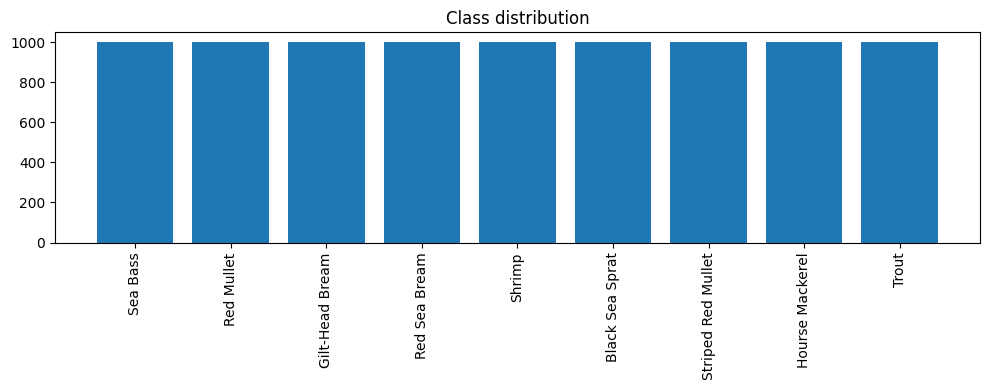

In [6]:
all_images = [p for p in CLEAN_DIR.glob(
    "*/*") if p.suffix.lower() in (".jpg", ".jpeg", ".png")]
classes = sorted([d.name for d in CLEAN_DIR.iterdir() if d.is_dir()])

print("Total images:", len(all_images))
print("Number of classes:", len(classes))
print(classes)

labels = [p.parent.name for p in all_images]
class_counts = Counter(labels)

plt.figure(figsize=(10, 4))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title("Class distribution")
plt.tight_layout()
plt.show()

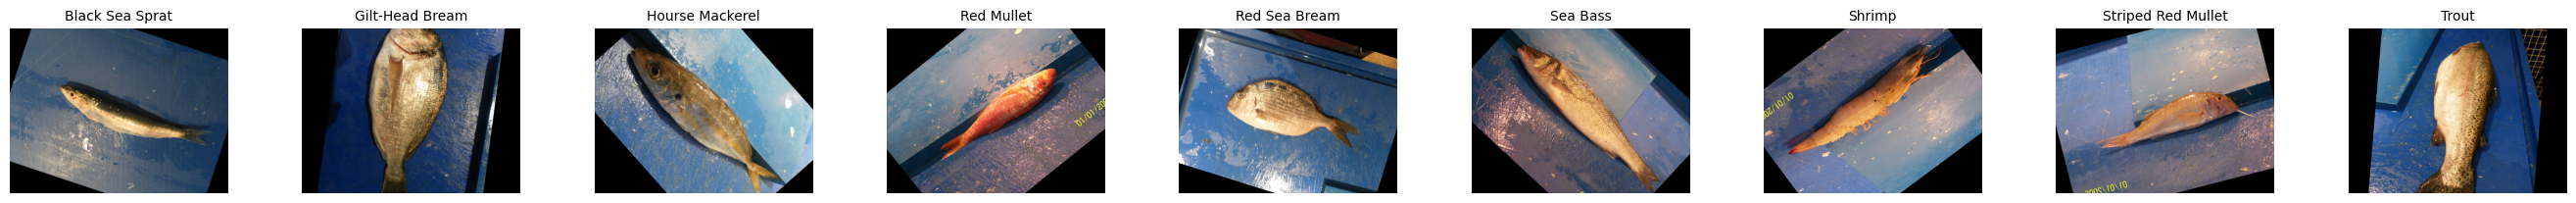

In [7]:
selected_images_paths = []

for class_name in classes:
    class_dir = CLEAN_DIR / class_name
    # Find all image files (case-insensitive for extensions)
    class_images = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        class_images.extend(list(class_dir.glob(ext)))

    if class_images:
        selected_images_paths.append(random.choice(class_images))

# Determine grid size for subplots
num_classes = len(selected_images_paths)
rows = 2
cols = num_classes

plt.figure(figsize=(cols * 3, 4))
for i, img_path in enumerate(selected_images_paths):
    plt.subplot(rows, cols, i + 1)
    img = Image.open(img_path)
    class_label = img_path.parent.name
    plt.imshow(img)
    plt.title(class_label, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4) Dataset + transforms


In [8]:
IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Random horizontal flipping is used as a data augmentation technique.
    # For fish species classification, left/right orientation does not change the label,
    # so flipping helps the model learn orientation-invariant features.
    # This increases data diversity, reduces overfitting, and improves generalization.
    transforms.RandomHorizontalFlip(p=0.5),
    # NEW (Suggestion #1): rotation robustness (fix sideways shrimp)
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
])

eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

base_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
num_classes = len(base_ds.classes)
num_classes, base_ds.classes

(9,
 ['Black Sea Sprat',
  'Gilt-Head Bream',
  'Hourse Mackerel',
  'Red Mullet',
  'Red Sea Bream',
  'Sea Bass',
  'Shrimp',
  'Striped Red Mullet',
  'Trout'])

## 5) Model


In [9]:
# class SmallCNN(nn.Module):
#     def __init__(self, num_classes):
#         super().__init__()
#         self.features = nn.Sequential(
#             # (3, 224, 224) -> (32, 224, 224)
#             nn.Conv2d(3, 32, 3, padding=1),
#             nn.ReLU(),
#             # (32, 224, 224) -> (32, 112, 112)
#             nn.MaxPool2d(2),
#             # (32, 112, 112) -> (64, 112, 112)
#             nn.Conv2d(32, 64, 3, padding=1),
#             nn.ReLU(),
#             # (64, 112, 112) -> (64, 56, 56)
#             nn.MaxPool2d(2),
#             # (64, 56, 56) -> (128, 56, 56)
#             nn.Conv2d(64, 128, 3, padding=1),
#             nn.ReLU(),
#             # (128, 56, 56) -> (128, 28, 28)
#             nn.MaxPool2d(2),
#         )
#         self.classifier = nn.Sequential(
#             # (128, 28, 28) -> (100352,)
#             nn.Flatten(),
#             # (100352,) -> (256,)
#             nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             # (256,) -> (num_classes,)  (logits for each class)
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         return self.classifier(self.features(x))


class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            # (N, 3, H, W) -> (N, 32, H, W)
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # -> (N, 32, H/2, W/2)
            nn.MaxPool2d(2),

            # -> (N, 64, H/2, W/2)
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # -> (N, 64, H/4, W/4)
            nn.MaxPool2d(2),

            # -> (N, 128, H/4, W/4)
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # -> (N, 128, H/8, W/8)
            nn.MaxPool2d(2),

            # -> (N, 128, 1, 1) regardless of input size
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),              # (N, 128, 1, 1) -> (N, 128)
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)  # logits
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

## 6) KFold training (K=5)


In [10]:
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    losses, preds, targets = [], [], []

    with torch.set_grad_enabled(is_train):
        for x, y in tqdm(loader, leave=False):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            losses.append(loss.item())
            # store the label predicted (max logit)
            preds.append(logits.argmax(dim=1).detach().cpu().numpy())
            targets.append(y.detach().cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    return float(np.mean(losses)), accuracy_score(targets, preds), preds, targets

In [11]:
@torch.no_grad()
def predict_proba(model, loader):
    model.eval()
    probs_all, y_all = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        probs_all.append(probs)
        y_all.append(y.numpy())
    return np.vstack(probs_all), np.concatenate(y_all)


@torch.no_grad()
def predict_proba_tta(model, loader, num_classes, use_hflip=True):
    model.eval()

    probs_all = []
    y_all = []

    for x, y in loader:
        x = x.to(device)  # (B, C, H, W)

        # collect probabilities from multiple augmented views
        probs_views = []

        # rotations: 0, 90, 180, 270
        for k in [0, 1, 2, 3]:
            x_rot = torch.rot90(x, k=k, dims=(2, 3))
            logits = model(x_rot)
            probs_views.append(torch.softmax(logits, dim=1))

            if use_hflip:
                # horizontal flip (W dimension)
                x_flip = torch.flip(x_rot, dims=(3,))
                logits_f = model(x_flip)
                probs_views.append(torch.softmax(logits_f, dim=1))

        # average across views -> (B, num_classes)
        probs_mean = torch.stack(probs_views, dim=0).mean(dim=0)

        probs_all.append(probs_mean.cpu().numpy())
        y_all.append(y.numpy())

    return np.vstack(probs_all), np.concatenate(y_all)


def plot_history(hist, title=""):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " accuracy")
    plt.show()

Train pool: 7200 Test: 1800 Classes: 9

===== Fold 1/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.550 val acc=0.806


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.793 val acc=0.692


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.858 val acc=0.842


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.891 val acc=0.760


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.916 val acc=0.708


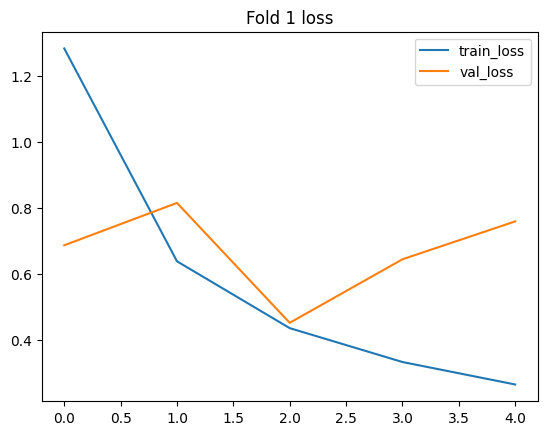

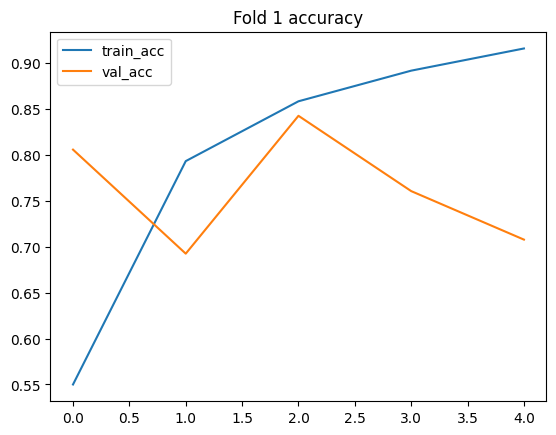

  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 03:39:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 2/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.542 val acc=0.666


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.766 val acc=0.567


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.855 val acc=0.614


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.894 val acc=0.778


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.917 val acc=0.714


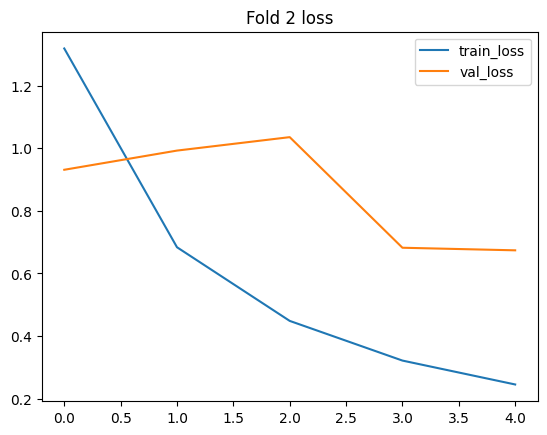

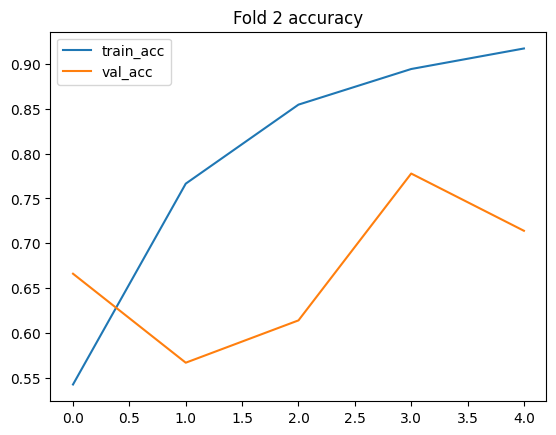

  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 04:00:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 3/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.539 val acc=0.523


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.785 val acc=0.791


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.862 val acc=0.620


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.897 val acc=0.877


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.921 val acc=0.674


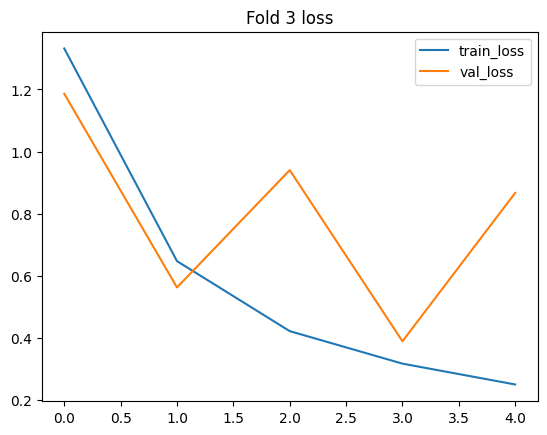

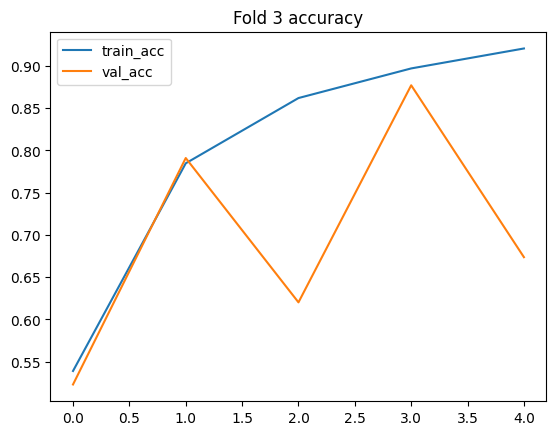

  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 04:22:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 4/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.531 val acc=0.487


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.808 val acc=0.740


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.875 val acc=0.898


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.907 val acc=0.683


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.932 val acc=0.576


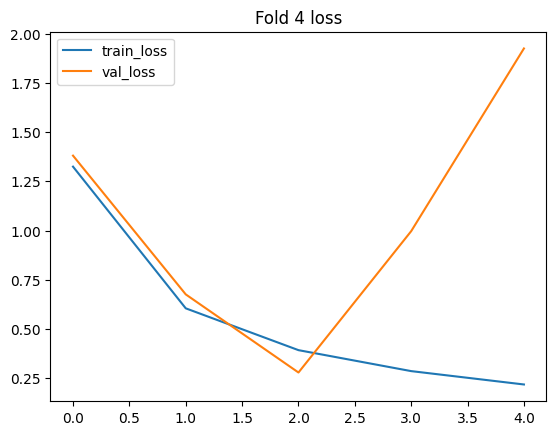

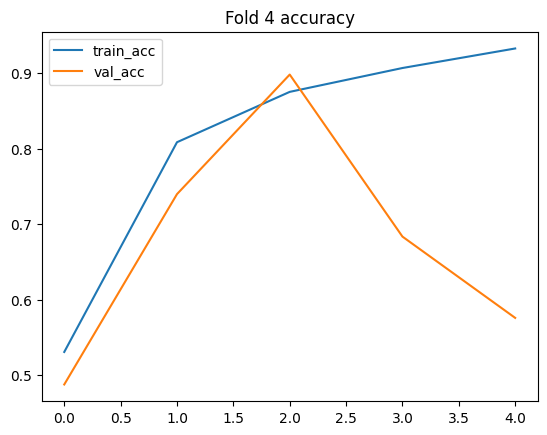

  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 04:44:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



===== Fold 5/5 =====


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.553 val acc=0.574


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.770 val acc=0.770


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 03: train acc=0.846 val acc=0.766


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 04: train acc=0.896 val acc=0.798


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 05: train acc=0.904 val acc=0.738


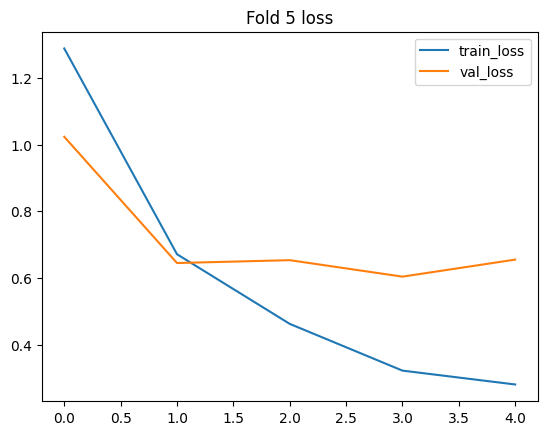

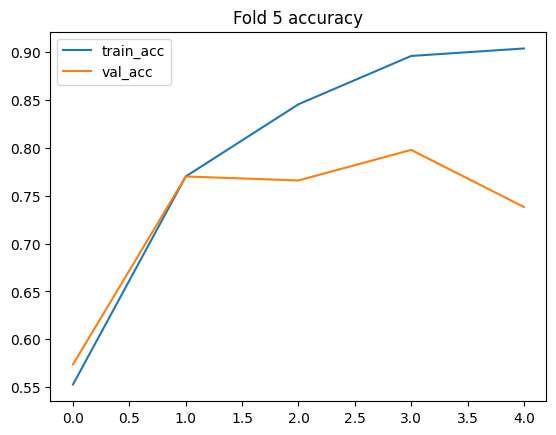

  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

2025/12/15 05:06:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


fold  train_loss  train_acc  val_loss   val_acc  test_loss  test_acc
0     1    0.753941   0.695833  0.758447  0.707639   0.805430  0.692222
1     2    0.685285   0.714583  0.673699  0.713889   0.690533  0.714444
2     3    0.883029   0.656250  0.866918  0.673611   0.860970  0.668333
3     4    1.860027   0.599479  1.924669  0.575694   1.913009  0.591667
4     5    0.676849   0.739931  0.654987  0.738194   0.693782  0.730000


=== Mean-of-folds ensemble (TEST) ===
Ensemble test loss: 0.5241183638572693
Ensemble test acc : 0.8988888888888888


fold  train_loss  train_acc  val_loss   val_acc  test_loss  test_acc  \
0     1    0.753941   0.695833  0.758447  0.707639   0.805430  0.692222   
1     2    0.685285   0.714583  0.673699  0.713889   0.690533  0.714444   
2     3    0.883029   0.656250  0.866918  0.673611   0.860970  0.668333   
3     4    1.860027   0.599479  1.924669  0.575694   1.913009  0.591667   
4     5    0.676849   0.739931  0.654987  0.738194   0.693782  0.730000   

   ensemble_test_acc  
0           0.898889  
1           0.898889  
2           0.898889  
3           0.898889  
4           0.898889

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import pandas as pd
import time

# --- Settings ---
K = 5
epochs = 5
batch_size = 32
lr = 1e-3

# --- Build a fixed TEST split (so "test" is real) ---
base_eval_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
y_all = np.array([y for _, y in base_eval_ds.samples])
idx_all = np.arange(len(y_all))

sss = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_pool_idx, test_idx = next(sss.split(idx_all, y_all))
y_train_pool = y_all[train_pool_idx]

test_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
test_loader = DataLoader(
    Subset(test_ds, test_idx),
    batch_size=batch_size, shuffle=False, num_workers=2
)

print("Train pool:", len(train_pool_idx), "Test:", len(
    test_idx), "Classes:", len(base_eval_ds.classes))

# --- KFold on the training pool ---
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_SEED)

fold_rows = []
fold_test_probs = []  # for mean-of-folds ensemble on TEST
test_targets = None

for fold, (tr_rel, va_rel) in enumerate(skf.split(np.zeros(len(train_pool_idx)), y_train_pool), start=1):
    print(f"\n===== Fold {fold}/{K} =====")

    tr_idx = train_pool_idx[tr_rel]
    va_idx = train_pool_idx[va_rel]

    # Train dataset uses augmentation; eval datasets do not
    train_ds = ImageFolder(CLEAN_DIR, transform=train_tf)
    train_eval_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)
    val_ds = ImageFolder(CLEAN_DIR, transform=eval_tf)

    train_loader = DataLoader(Subset(train_ds, tr_idx),
                              batch_size=batch_size, shuffle=True, num_workers=2)
    train_eval_loader = DataLoader(Subset(train_eval_ds, tr_idx),
                                   batch_size=batch_size, shuffle=False, num_workers=2)
    val_loader = DataLoader(Subset(val_ds, va_idx),
                            batch_size=batch_size, shuffle=False, num_workers=2)

    model = SmallCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    run_name = f"fold_{fold}"
    start_time = time.time()

    with mlflow.start_run(run_name=run_name):
        mlflow.log_params({
            "dataset": "fish_classification_clean (ImageFolder)",
            "clean_dir": str(CLEAN_DIR),
            "model": "SmallCNN",
            "num_classes": int(num_classes),
            "img_size": int(IMG_SIZE),
            "k_folds": int(K),
            "epochs": int(epochs),
            "batch_size": int(batch_size),
            "lr": float(lr),
            "seed": int(RANDOM_SEED),
            "fold": int(fold),
        })

        for ep in range(1, epochs + 1):
            tr_loss, tr_acc, _, _ = run_epoch(
                model, train_loader, criterion, optimizer)
            va_loss, va_acc, _, _ = run_epoch(model, val_loader, criterion)

            hist["train_loss"].append(tr_loss)
            hist["train_acc"].append(tr_acc)
            hist["val_loss"].append(va_loss)
            hist["val_acc"].append(va_acc)

            print(
                f"Epoch {ep:02d}: train acc={tr_acc:.3f} val acc={va_acc:.3f}")

            mlflow.log_metrics({
                "train_loss": float(tr_loss),
                "train_acc": float(tr_acc),
                "val_loss": float(va_loss),
                "val_acc": float(va_acc),
            }, step=ep)

        # Show learning curves (still displayed in the notebook)
        plot_history(hist, title=f"Fold {fold}")

        # Final metrics: train (clean eval), val, test
        train_loss, train_acc, _, _ = run_epoch(
            model, train_eval_loader, criterion)
        val_loss, val_acc, _, _ = run_epoch(model, val_loader, criterion)
        test_loss, test_acc, _, _ = run_epoch(model, test_loader, criterion)

        mlflow.log_metrics({
            "final_train_loss": float(train_loss),
            "final_train_acc": float(train_acc),
            "final_val_loss": float(val_loss),
            "final_val_acc": float(val_acc),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
            "runtime_sec": float(time.time() - start_time),
        })

        # Store test probabilities for ensemble
        probs, test_targets = predict_proba(model, test_loader)
        fold_test_probs.append(probs)

        # Log the model (optional but useful)
        mlflow.pytorch.log_model(model, artifact_path="model")

        fold_rows.append({
            "fold": fold,
            "train_loss": float(train_loss),
            "train_acc": float(train_acc),
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
            "test_loss": float(test_loss),
            "test_acc": float(test_acc),
        })

df_folds = pd.DataFrame(fold_rows)
display(df_folds)

# --- Mean-of-folds ensemble on TEST ---
mean_probs = np.mean(np.stack(fold_test_probs, axis=0), axis=0)
mean_pred = mean_probs.argmax(axis=1)

ensemble_test_acc = float(accuracy_score(test_targets, mean_pred))
eps = 1e-12
ensemble_test_loss = float(
    np.mean(-np.log(mean_probs[np.arange(len(test_targets)), test_targets] + eps)))

print("\n=== Mean-of-folds ensemble (TEST) ===")
print("Ensemble test loss:", ensemble_test_loss)
print("Ensemble test acc :", ensemble_test_acc)

# Log ensemble summary in its own MLflow run
with mlflow.start_run(run_name="ensemble_mean_of_folds"):
    mlflow.log_params({
        "dataset": "fish_classification_clean (ImageFolder)",
        "clean_dir": str(CLEAN_DIR),
        "model_family": "SmallCNN (per-fold) -> mean-prob ensemble",
        "num_classes": int(num_classes),
        "img_size": int(IMG_SIZE),
        "k_folds": int(K),
        "epochs": int(epochs),
        "batch_size": int(batch_size),
        "lr": float(lr),
        "seed": int(RANDOM_SEED),
    })
    mlflow.log_metrics({
        "ensemble_test_loss": float(ensemble_test_loss),
        "ensemble_test_acc": float(ensemble_test_acc),
    })
    mlflow.log_text(df_folds.to_csv(index=False), "fold_metrics.csv")

# Compare per-fold test acc vs ensemble acc
df_compare = df_folds.copy()
df_compare["ensemble_test_acc"] = ensemble_test_acc
display(df_compare)

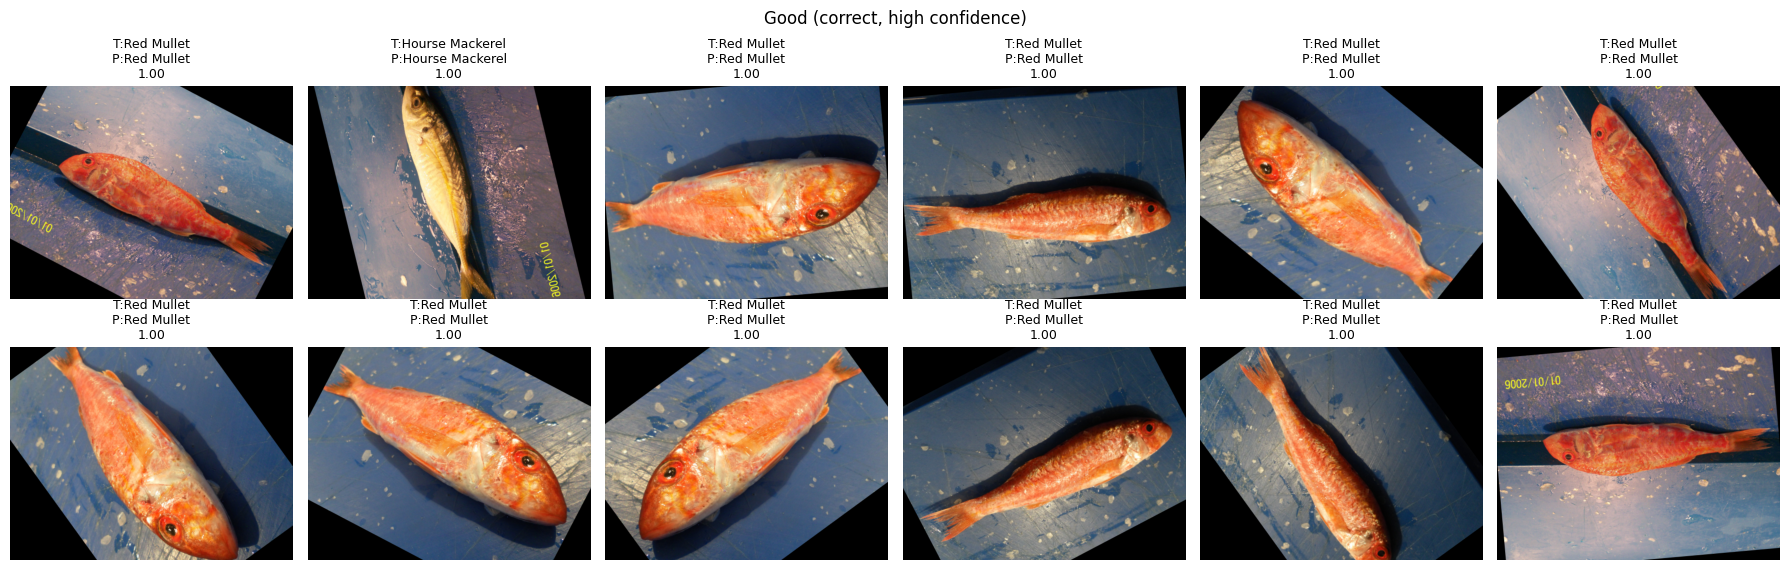

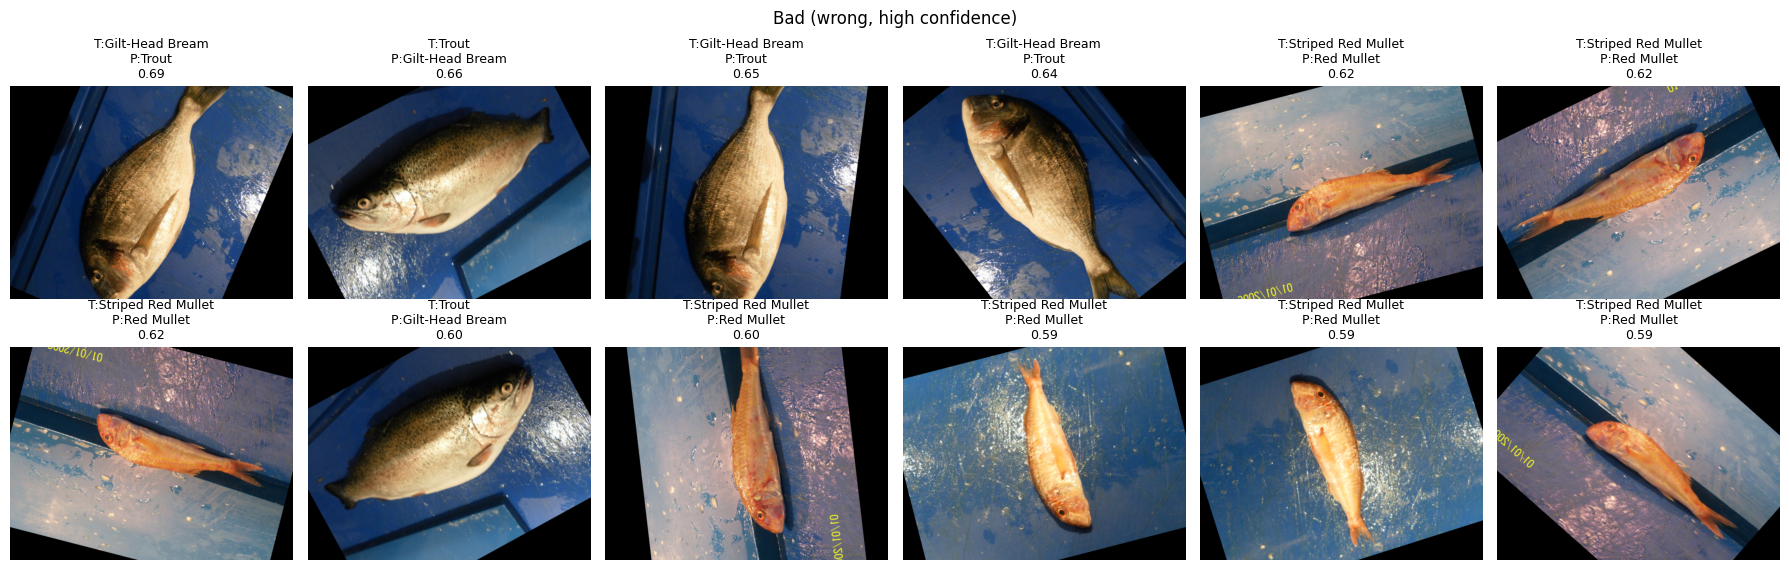

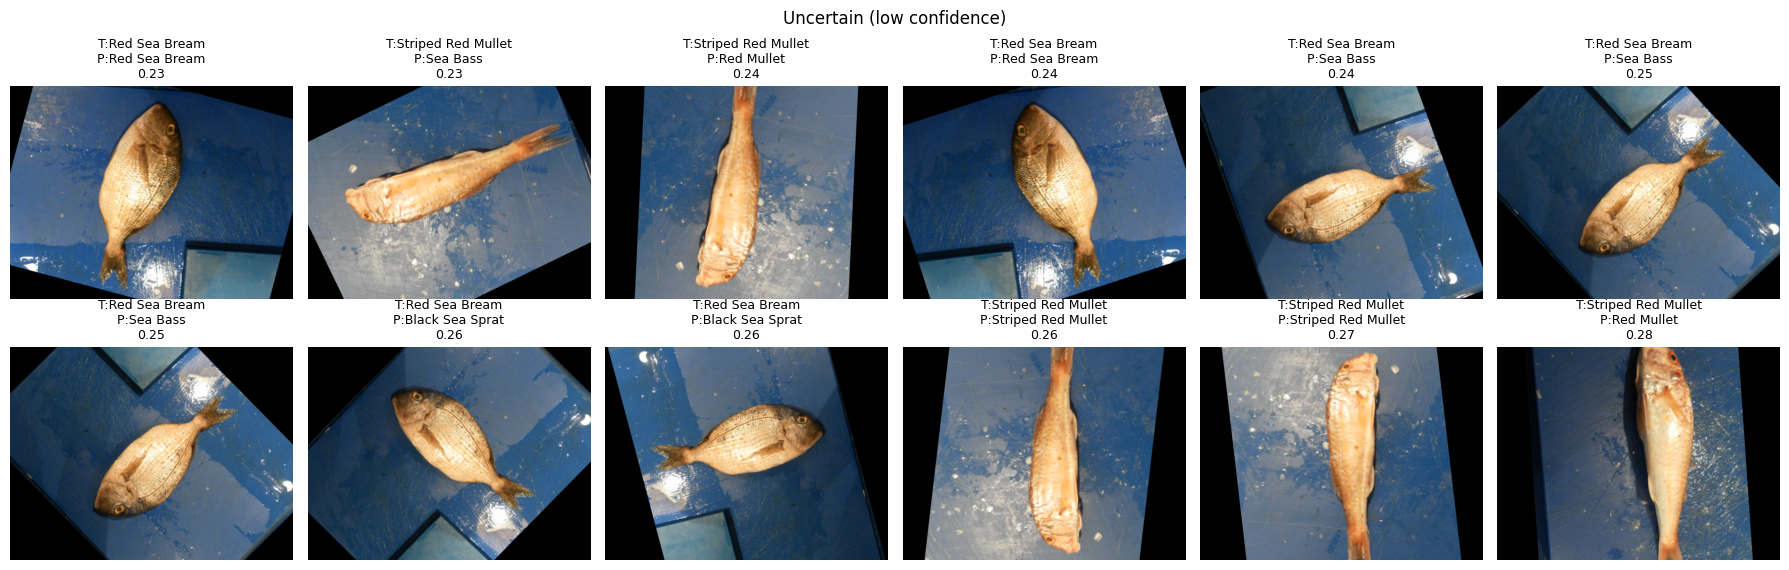

In [13]:
def show_examples(title, chosen_indices, subset_indices, probs, y_true, class_names, max_cols=6):
    cols = min(max_cols, len(chosen_indices))
    rows = int(np.ceil(len(chosen_indices) / cols))
    plt.figure(figsize=(cols * 3, rows * 3))
    plt.suptitle(title)

    for j, i in enumerate(chosen_indices):
        global_idx = subset_indices[i]
        img_path, yt = base_eval_ds.samples[global_idx]
        img = Image.open(img_path).convert("RGB")

        yp = int(probs[i].argmax())
        conf = float(probs[i].max())

        ax = plt.subplot(rows, cols, j + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(
            f"T:{class_names[yt]}\nP:{class_names[yp]}\n{conf:.2f}", fontsize=9)

    plt.tight_layout()
    plt.show()


# Build y_true for test subset in same order as mean_probs
test_subset_indices = test_idx
y_true_test = np.array([base_eval_ds.samples[i][1]
                       for i in test_subset_indices])
class_names = base_eval_ds.classes

y_pred = mean_probs.argmax(axis=1)
conf = mean_probs.max(axis=1)

correct = np.where(y_pred == y_true_test)[0]
wrong = np.where(y_pred != y_true_test)[0]
uncertain = np.argsort(conf)[:12]  # lowest confidence

good_sorted = correct[np.argsort(-conf[correct])]
bad_sorted = wrong[np.argsort(-conf[wrong])]

show_examples("Good (correct, high confidence)",
              good_sorted[:12], test_subset_indices, mean_probs, y_true_test, class_names)
show_examples("Bad (wrong, high confidence)",
              bad_sorted[:12], test_subset_indices, mean_probs, y_true_test, class_names)
show_examples("Uncertain (low confidence)",
              uncertain[:12], test_subset_indices, mean_probs, y_true_test, class_names)

The model misclassifies shrimps that are horizontal,
we have 3 suggestes:
1.	Add rotation augmentation (most important here)
Teach the model that “shrimp sideways is still shrimp”.
	2.	Normalize inputs + stabilize conv blocks (BatchNorm)
Normalization helps optimization; BatchNorm improves training stability and often generalization.
  3.	Increase model capacity (more filters / deeper)

# Part 3 — Transfer Learning with 4 pretrained architectures (torchvision)
We will fine-tune 4 pretrained models, compare validation/test metrics, compute “unique correct / unique errors” on the test set,
then train a classical ML classifier on deep features from the best model.

In [14]:
import time
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.models as models

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [15]:
RANDOM_SEED = 42  # keep same
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Build a fixed TEST split (20%)
base_eval_ds = ImageFolder(CLEAN_DIR, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))
y_all = np.array([y for _, y in base_eval_ds.samples])
idx_all = np.arange(len(y_all))

sss_test = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
train_pool_idx, test_idx = next(sss_test.split(idx_all, y_all))

# Build a fixed VAL split inside the train_pool (20% of train_pool)
y_train_pool = y_all[train_pool_idx]
sss_val = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
tr_rel, va_rel = next(sss_val.split(
    np.zeros(len(train_pool_idx)), y_train_pool))
train_idx = train_pool_idx[tr_rel]
val_idx = train_pool_idx[va_rel]

print("Train:", len(train_idx), "Val:", len(val_idx), "Test:",
      len(test_idx), "Classes:", len(base_eval_ds.classes))
num_classes = len(base_eval_ds.classes)
class_names = base_eval_ds.classes

Train: 5760 Val: 1440 Test: 1800 Classes: 9


In [16]:
def build_tforms_from_weights(weights, train_aug=True):
    # Official preprocessing for this pretrained weights object
    base_preprocess = weights.transforms()

    if not train_aug:
        return base_preprocess

    # Add label-preserving augmentations BEFORE the pretrained preprocessing.
    # (These operate on PIL images; base_preprocess will handle resize/tensor/normalize.)
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=90),  # helps sideways shrimp
        base_preprocess,
    ])

In [17]:
def make_loaders(train_transform, eval_transform, batch_size=32, num_workers=2):
    train_ds = ImageFolder(CLEAN_DIR, transform=train_transform)
    val_ds = ImageFolder(CLEAN_DIR, transform=eval_transform)
    test_ds = ImageFolder(CLEAN_DIR, transform=eval_transform)

    train_loader = DataLoader(Subset(
        train_ds, train_idx), batch_size=batch_size, shuffle=True,  num_workers=num_workers)
    val_loader = DataLoader(Subset(
        val_ds,   val_idx),   batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(Subset(
        test_ds,  test_idx),  batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, test_loader

In [18]:
def make_pretrained_model(model_name, num_classes):
    if model_name == "resnet18":
        weights = models.ResNet18_Weights.DEFAULT
        model = models.resnet18(weights=weights)
        in_f = model.fc.in_features
        model.fc = nn.Linear(in_f, num_classes)
        return model, weights

    if model_name == "efficientnet_b0":
        weights = models.EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, num_classes)
        return model, weights

    if model_name == "vgg16_bn":
        weights = models.VGG16_BN_Weights.DEFAULT
        model = models.vgg16_bn(weights=weights)
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, num_classes)
        return model, weights

    if model_name == "densenet121":
        weights = models.DenseNet121_Weights.DEFAULT
        model = models.densenet121(weights=weights)
        in_f = model.classifier.in_features
        model.classifier = nn.Linear(in_f, num_classes)
        return model, weights

    raise ValueError(f"Unknown model_name: {model_name}")


def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [19]:
def finetune_and_eval(model, train_loader, val_loader, test_loader, epochs=2, lr=1e-4, weight_decay=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    t0 = time.perf_counter()
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc, _, _ = run_epoch(
            model, train_loader, criterion, optimizer)
        va_loss, va_acc, _, _ = run_epoch(model, val_loader, criterion)

        hist["train_loss"].append(tr_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss)
        hist["val_acc"].append(va_acc)

        print(f"Epoch {ep:02d}: train acc={tr_acc:.3f} val acc={va_acc:.3f}")
    runtime_sec = time.perf_counter() - t0

    # Final eval on val + test (also keep test preds for uniqueness)
    val_loss, val_acc, _, _ = run_epoch(model, val_loader, criterion)
    test_loss, test_acc, test_pred, test_true = run_epoch(
        model, test_loader, criterion)

    return {
        "model": model,
        "hist": hist,
        "runtime_sec": runtime_sec,
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "test_pred": test_pred,
        "test_true": test_true,
    }


Training: resnet18
ResNet18_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.957 val acc=1.000


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.998 val acc=1.000


  0%|          | 0/45 [00:01<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

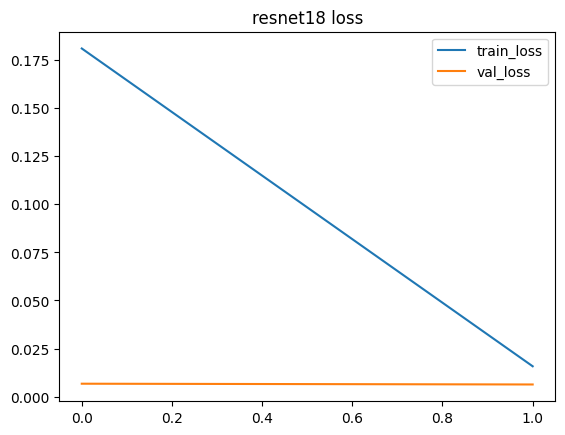

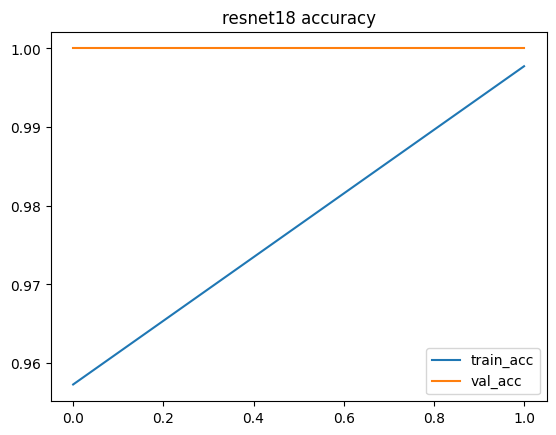


Training: efficientnet_b0
EfficientNet_B0_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.911 val acc=1.000


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.996 val acc=1.000


  0%|          | 0/45 [00:01<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

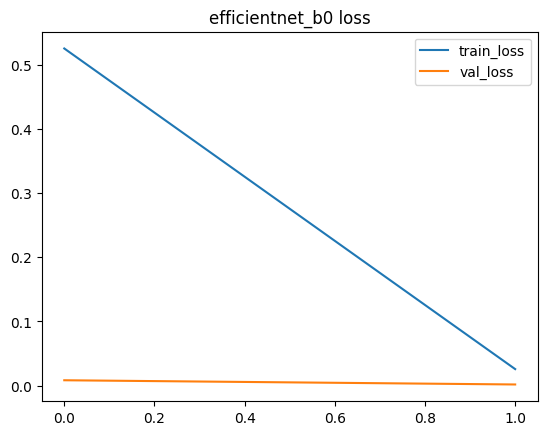

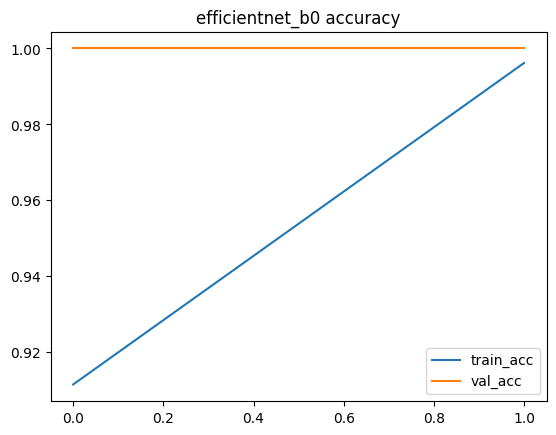


Training: vgg16_bn
VGG16_BN_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.947 val acc=0.991


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=0.991 val acc=0.997


  0%|          | 0/45 [00:01<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

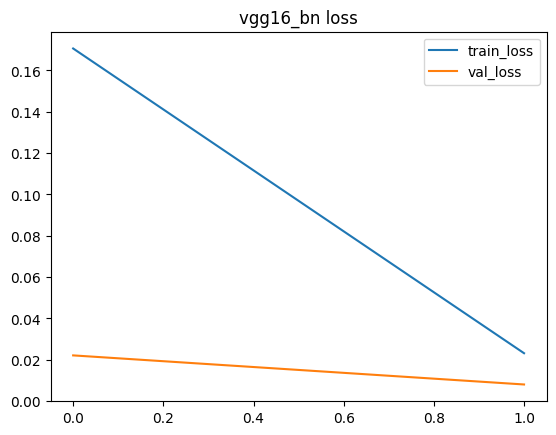

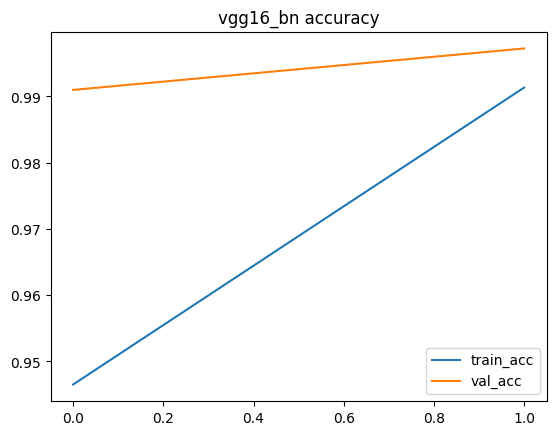


Training: densenet121
DenseNet121_Weights.IMAGENET1K_V1


  0%|          | 0/180 [00:02<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 01: train acc=0.962 val acc=1.000


  0%|          | 0/180 [00:01<?, ?it/s]

  0%|          | 0/45 [00:02<?, ?it/s]

Epoch 02: train acc=1.000 val acc=1.000


  0%|          | 0/45 [00:01<?, ?it/s]

  0%|          | 0/57 [00:02<?, ?it/s]

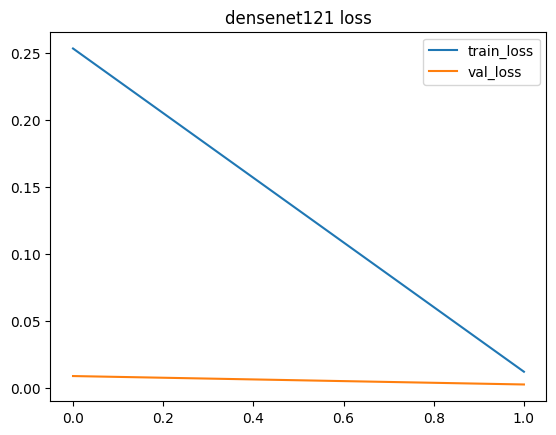

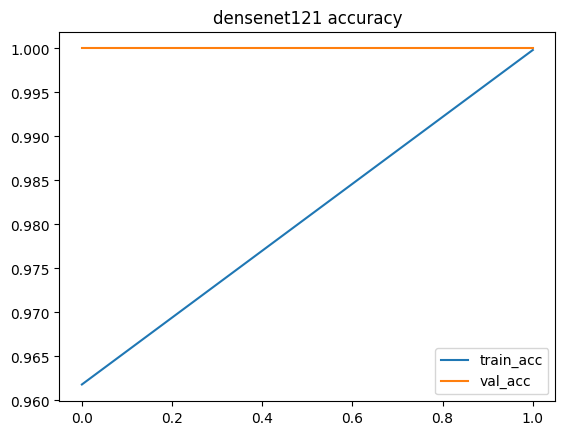

Model Name  # parameters  Validation Loss  Validation Accuracy  \
0         resnet18      11181129         0.006320             1.000000   
1  efficientnet_b0       4019077         0.001625             1.000000   
2         vgg16_bn     134305865         0.008016             0.997222   
3      densenet121       6963081         0.002804             1.000000   

   Test Loss  Test Accuracy  runtime_sec  
0   0.007805       1.000000   943.829389  
1   0.001592       1.000000  3428.228582  
2   0.006642       0.997778  4938.970077  
3   0.002705       1.000000  2997.548859

In [20]:
MODEL_NAMES = ["resnet18", "efficientnet_b0", "vgg16_bn", "densenet121"]

rows = []
test_correct_matrix = {}   # name -> boolean array on test set
# name -> trained model object (for feature extractor step)
trained_models = {}

for name in MODEL_NAMES:
    print("\n==============================")
    print("Training:", name)

    model, weights = make_pretrained_model(name, num_classes)
    total_p, trainable_p = count_params(model)

    print(weights)
    train_tf_m = build_tforms_from_weights(weights, train_aug=True)
    eval_tf_m = build_tforms_from_weights(weights, train_aug=False)
    train_loader, val_loader, test_loader = make_loaders(
        train_tf_m, eval_tf_m, batch_size=32, num_workers=2)

    out = finetune_and_eval(model, train_loader, val_loader,
                            test_loader, epochs=2, lr=1e-4, weight_decay=1e-4)

    # learning curves (optional but usually useful for report)
    plot_history(out["hist"], title=name)

    y_true = out["test_true"]
    y_pred = out["test_pred"]
    correct = (y_pred == y_true)
    test_correct_matrix[name] = correct
    trained_models[name] = out["model"]

    rows.append({
        "Model Name": name,
        "# parameters": total_p,
        "Validation Loss": out["val_loss"],
        "Validation Accuracy": out["val_acc"],
        "Test Loss": out["test_loss"],
        "Test Accuracy": out["test_acc"],
        "runtime_sec": out["runtime_sec"],
    })

df_models = pd.DataFrame(rows)
display(df_models)

In [21]:
names = MODEL_NAMES
C = np.stack([test_correct_matrix[n] for n in names], axis=0)  # (M, Ntest)

unique_correct = {}
unique_errors = {}

for i, name in enumerate(names):
    this = C[i]
    others = np.delete(C, i, axis=0)

    unique_correct[name] = int(np.sum(this & (~others.any(axis=0))))
    unique_errors[name] = int(np.sum((~this) & (others.all(axis=0))))

df_models["# unique correct samples"] = df_models["Model Name"].map(
    unique_correct)
df_models["# unique errors"] = df_models["Model Name"].map(unique_errors)

display(df_models)

Model Name  # parameters  Validation Loss  Validation Accuracy  \
0         resnet18      11181129         0.006320             1.000000   
1  efficientnet_b0       4019077         0.001625             1.000000   
2         vgg16_bn     134305865         0.008016             0.997222   
3      densenet121       6963081         0.002804             1.000000   

   Test Loss  Test Accuracy  runtime_sec  # unique correct samples  \
0   0.007805       1.000000   943.829389                         0   
1   0.001592       1.000000  3428.228582                         0   
2   0.006642       0.997778  4938.970077                         0   
3   0.002705       1.000000  2997.548859                         0   

   # unique errors  
0                0  
1                0  
2                4  
3                0

In [22]:
best_name = df_models.sort_values(
    "Validation Accuracy", ascending=False).iloc[0]["Model Name"]
print("Best by val acc:", best_name)

# Rebuild transforms/loaders for the best model
best_model, best_weights = make_pretrained_model(best_name, num_classes)
best_model = trained_models[best_name]  # use the trained one
eval_tf_best = build_tforms_from_weights(best_weights, train_aug=False)

# Build datasets/loaders for feature extraction: use ALL train_pool (train+val) vs test
trainpool_ds = ImageFolder(CLEAN_DIR, transform=eval_tf_best)
test_ds = ImageFolder(CLEAN_DIR, transform=eval_tf_best)

trainpool_loader = DataLoader(Subset(
    trainpool_ds, train_pool_idx), batch_size=64, shuffle=False, num_workers=2)
test_loader_feat = DataLoader(
    Subset(test_ds, test_idx),          batch_size=64, shuffle=False, num_workers=2)


@torch.no_grad()
def extract_features(model, loader, model_name):
    model.eval().to(device)
    feats, ys = [], []

    for x, y in loader:
        x = x.to(device)

        if model_name.startswith("resnet"):
            # forward until avgpool
            z = model.conv1(x)
            z = model.bn1(z)
            z = model.relu(z)
            z = model.maxpool(z)
            z = model.layer1(z)
            z = model.layer2(z)
            z = model.layer3(z)
            z = model.layer4(z)
            z = model.avgpool(z)
            z = torch.flatten(z, 1)

        elif model_name.startswith("efficientnet"):
            z = model.features(x)
            z = model.avgpool(z)
            z = torch.flatten(z, 1)

        elif model_name.startswith("vgg"):
            z = model.features(x)
            z = model.avgpool(z)
            z = torch.flatten(z, 1)

        elif model_name.startswith("densenet"):
            z = model.features(x)
            z = nn.functional.relu(z, inplace=False)
            z = nn.functional.adaptive_avg_pool2d(z, (1, 1))
            z = torch.flatten(z, 1)

        else:
            raise ValueError("Unsupported for feature extraction:", model_name)

        feats.append(z.cpu().numpy())
        ys.append(y.numpy())

    return np.vstack(feats), np.concatenate(ys)


X_train, y_train = extract_features(best_model, trainpool_loader, best_name)
X_test,  y_test = extract_features(best_model, test_loader_feat, best_name)

print("Feature shape:", X_train.shape, "Test shape:", X_test.shape)

clf = LogisticRegression(max_iter=2000, n_jobs=-1,
                         solver="saga", multi_class="multinomial")
clf.fit(X_train, y_train)
y_pred_lr = clf.predict(X_test)

lr_acc = float(accuracy_score(y_test, y_pred_lr))
print("LogReg-on-features test acc:", lr_acc)

# Compare to the CNN test acc from df_models
cnn_acc = float(df_models[df_models["Model Name"] ==
                best_name]["Test Accuracy"].iloc[0])
print("CNN test acc (best model):", cnn_acc)

Best by val acc: resnet18
Feature shape: (7200, 512) Test shape: (1800, 512)


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg-on-features test acc: 1.0
CNN test acc (best model): 1.0


/opt/homebrew/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
df_summary = df_models.copy()
df_summary["epochs"] = 2
df_summary["batch_size"] = 32
df_summary["lr"] = 1e-4
df_summary["weight_decay"] = 1e-4
df_summary["train_aug"] = "Resize+HFlip+Rot90"
df_summary["eval_preprocess"] = "Resize+Normalize(weights mean/std)"

display(df_summary.sort_values("Validation Accuracy", ascending=False))

Model Name  # parameters  Validation Loss  Validation Accuracy  \
0         resnet18      11181129         0.006320             1.000000   
1  efficientnet_b0       4019077         0.001625             1.000000   
3      densenet121       6963081         0.002804             1.000000   
2         vgg16_bn     134305865         0.008016             0.997222   

   Test Loss  Test Accuracy  runtime_sec  # unique correct samples  \
0   0.007805       1.000000   943.829389                         0   
1   0.001592       1.000000  3428.228582                         0   
3   0.002705       1.000000  2997.548859                         0   
2   0.006642       0.997778  4938.970077                         0   

   # unique errors  epochs  batch_size      lr  weight_decay  \
0                0       2          32  0.0001        0.0001   
1                0       2          32  0.0001        0.0001   
3                0       2          32  0.0001        0.0001   
2                4       2          32  0.0001        0.0001   

            train_aug                     eval_preprocess  
0  Resize+HFlip+Rot90  Resize+Normalize(weights mean/std)  
1  Resize+HFlip+Rot90  Resize+Normalize(weights mean/std)  
3  Resize+HFlip+Rot90  Resize+Normalize(weights mean/std)  
2  Resize+HFlip+Rot90  Resize+Normalize(weights mean/std)